In [93]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from collections import deque
import random
import gym

# シミュレーション条件
EPISODES_MAX = 200000 # エピソード
STEPS_MAX = 30
DT = 0.01  # 時間ステップ
THRESHOLD = 0.03
THRESHOLD_REWARD = - 0.9
GOAL_POS = [0.0, 1.0]
THETA_INIT = 60 # [deg]
STEPS_INIT = 0
WARMUP_EPISODE = 15000
EVAL_INTERVAL = 100
SUCCESS_THRESHOLD_HIGH = 0.8
SUCCESS_THRESHOLD_LOW = 0.5


# 制御対象
L = 1.0  # アームの長さ
THETA_MAX = 180
THETA_MIN = 0


# 強化学習のパラメータ
ACTION_MIN = - 200 # [deg/s]
ACTION_MAX = 200 # [deg/s]
STATE_THETA_MAX = np.pi
STATE_THETA_MIN = 0.0
REWARD_G = 30
REWARD_D = 300
REWARD_P_JE = 0.00000000001
REWARD_JE_LIM = 0.000000001
REWARD_P_V = 5.0
REWARD_P_T = 0.3
REWARD_STD_V = 1.0
REWARD_STD_T = 0.1
REWARD_STD_J = 10
TIME_PUNISH = 0.3
ALPHA = 0.5
BUFFER_SIZE = 1000000 #30000 episodes分
WARMUP_SIZE = 200000
TRAIN_INTARVAL = 10
BATCH_SIZE = 128
SIGMA = 0.9
SOFT_TARGET_TAU = 0.02
HARD_TARGET_INTERVAL = 100
LOG_2PI = tf.constant(np.log(2.0 * np.pi), dtype=tf.float32)


# ニューラルネットワークのパラメータ
GAMMA = 0.99
GAMMA_P = 0.003
GAMMA_V = 0.01
RAYER_INPUT = 3
RAYER_OUTPUT_V = 1
RAYER_OUTPUT_M = 1
RAYER_OUTPUT_S = 1
RAYER_HIDDEN =32

# データ保存
SAVE_INTERVAL = 10000  # 1000エピソードごとに詳細データを保存

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [94]:
import gym
import numpy as np

class OneJointReachingEnv(gym.Env):
    """1関節アームのリーチング運動環境"""

    def __init__(self):
        super().__init__()

        # シミュレーションパラメータ（外部定義が必要）
        self.dt = DT                          # 時間刻み幅
        self.l = L                            # アームの長さ
        self.max_steps = STEPS_MAX            # 最大ステップ数
        self.goal_threshold = THRESHOLD       # ゴール判定閾値
        self.reward_j = 0          # 躍度ペナルティ重み

        # 状態空間：[角度, 角速度, 経過時間]
        self.observation_space = gym.spaces.Box(
            low=np.array([STATE_THETA_MIN, ACTION_MIN, 0]),
            high=np.array([STATE_THETA_MAX, ACTION_MAX, 1]),
            shape=(3,), dtype=np.float32
        )

        # アクション空間：角速度（ラジアン）
        self.action_space = gym.spaces.Box(
            low=np.radians(ACTION_MIN),
            high=np.radians(ACTION_MAX),
            shape=(1,), dtype=np.float32
        )

        # 目標座標
        self.goal_pos = np.array(GOAL_POS)

        self.reset()

    def set_penalty_weight(self, new_weight):
        """躍度ペナルティの重みを外部から設定"""
        self.reward_j = new_weight

    def reached_goal(self, dist_to_goal):
        """目標まで到達したかを判定"""
        return dist_to_goal <= self.goal_threshold

    def _get_obs(self):
        """現在の観測状態を返す"""
        return np.array([self.theta, self.theta_vel, self.steps / self.max_steps], dtype=np.float32)

    def calicuram(self, episode):
        """カスタム報酬調整用関数（用途に応じて利用）"""
        return (episode / EPISODES_MAX) * 20

    def reset(self):
        """環境のリセット"""
        self.theta = np.radians(THETA_INIT)
        self.steps = STEPS_INIT

        self.theta_vel = 0.0
        self.theta_acc = 0.0
        self.theta_jerk = 0.0

        self.jerk_sum = 0.0
        self.jerk_mem = 0.0
        self.reward_dist = 0.0

        return self._get_obs()

    def step(self, action):
        """1ステップの実行"""

        # 直前の状態を記録
        prev_theta = self.theta
        prev_vel = self.theta_vel
        prev_acc = self.theta_acc

        # 角度の更新（クリッピングあり）
        self.theta += np.clip(action[0], ACTION_MIN, ACTION_MAX) * self.dt
        self.theta = np.clip(self.theta, THETA_MIN, np.radians(THETA_MAX))

        # 動力学の更新（速度・加速度・躍度）
        self.update_dynamics(prev_theta, prev_vel, prev_acc)

        # 躍度の累積
        self.jerk_sum += self.dt * self.theta_jerk ** 2
        self.steps += 1

        # 手先位置と目標までの距離
        hand_pos = self.l * np.array([np.cos(self.theta), np.sin(self.theta)])
        dist_to_goal = np.linalg.norm(hand_pos - self.goal_pos)

        # 報酬内訳
        if self.steps < self.max_steps:
            reward_components = {
                "reward_dist": 0.0,
                "penalty_jerk": 0.0,
                "penalty_vel": 0.0,
                "penalty_time": 0.0,
            }
        else:
            reward_components = {
                "reward_dist": -REWARD_D * dist_to_goal**2,
                "penalty_jerk": -self.reward_j * self.jerk_sum,
                "penalty_vel": -REWARD_P_V * self.theta_vel**2,
                "penalty_time": 0.0
            }

        # 合計報酬
        reward = sum(reward_components.values())

        # 終了条件
        done = self.steps >= self.max_steps

        # デバッグ用情報
        info = {
            "hand_pos": hand_pos,
            "theta_vel": self.theta_vel,
            "theta_acc": self.theta_acc,
            "theta_jerk": self.theta_jerk,
            "dist_to_goal": dist_to_goal,
            "reward_total": reward,
            **reward_components
        }

        return self._get_obs(), reward, done, info

    def update_dynamics(self, prev_theta, prev_vel, prev_acc):
        """関節の運動量（速度・加速度・躍度）の更新"""
        self.theta_vel = (self.theta - prev_theta) / self.dt
        self.theta_acc = (self.theta_vel - prev_vel) / self.dt
        self.theta_jerk = (self.theta_acc - prev_acc) / self.dt

    



In [95]:
class PolicyModel(keras.Model):
    """Soft Actor-Critic 用の方策モデル（Squashed Gaussian）"""

    def __init__(self, action_space):
        super().__init__()
        self.action_space = action_space

        # アクション空間のスケーリング情報
        self.action_center = (action_space.high + action_space.low) / 2.0
        self.action_scale = (action_space.high - action_space.low) / 2.0

        # ネットワーク構造（入力3次元：角度・速度・時間）
        self.hidden1 = keras.layers.Dense(RAYER_HIDDEN, activation="relu", input_shape=(3,))
        self.hidden2 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.hidden3 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")

        # 平均と対数標準偏差（出力次元はアクション次元）
        self.mean_layer = keras.layers.Dense(action_space.shape[0], activation="linear")
        self.log_std_layer = keras.layers.Dense(action_space.shape[0], activation="linear")

        # オプティマイザ（学習率は適宜調整）
        self.optimizer = Adam(learning_rate=0.003)

    def call(self, inputs, training=False):
        """平均と標準偏差を出力（正規分布のパラメータ）"""
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)

        mean = self.mean_layer(x)
        log_std = tf.clip_by_value(self.log_std_layer(x), -20.0, 2.0)  # 安定化のためクリップ
        stddev = tf.exp(log_std)

        return mean, stddev

    @tf.function
    def sample_actions(self, states, training=False):
        """アクションをサンプル（Squashed Gaussian Policy）"""
        mean, stddev = self(states, training)
        normal_sample = tf.random.normal(mean.shape)

        # 学習時はサンプル、推論時は平均のみ
        raw_action = mean + stddev * normal_sample if training else mean
        squashed_action = tf.tanh(raw_action)  # [-1, 1] に変換

        return squashed_action, mean, stddev, raw_action

    def sample_action(self, states, training=False):
        """環境用にアクションをスケーリングして返す"""
        states = states.reshape(1, -1)
        squashed_action, _, _, _ = self.sample_actions(states, training)
        squashed_action = squashed_action.numpy()[0]

        # 環境用のスケーリング（実アクション空間へ）
        env_action = squashed_action * self.action_scale + self.action_center
        return env_action, squashed_action


In [96]:
class DualQNetwork(keras.Model):
    def __init__(self):
        super().__init__()

        # Q1ネットワーク（入力: 状態3次元 + アクション1次元 = 4次元）
        self.dense1 = keras.layers.Dense(RAYER_HIDDEN, activation="relu", input_shape=(4,))
        self.dense2 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.dense3 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.dense4 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.value1 = keras.layers.Dense(RAYER_HIDDEN, activation="linear")

        # Q2ネットワーク（同様に）
        self.dense5 = keras.layers.Dense(RAYER_HIDDEN, activation="relu", input_shape=(4,))
        self.dense6 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.dense7 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.dense8 = keras.layers.Dense(RAYER_HIDDEN, activation="relu")
        self.value2 = keras.layers.Dense(RAYER_OUTPUT_V, activation="linear")

        # 最適化手法
        self.optimizer = Adam(learning_rate=0.003)

    def call(self, states, actions, training=False):
        x = tf.concat([states, actions], axis=1)  # shape: (batch, 4)

        # Q1分岐
        x1 = self.dense1(x)
        x1 = self.dense2(x1)
        x1 = self.dense3(x1)
        x1 = self.dense4(x1)
        q1 = self.value1(x1)

        # Q2分岐
        x2 = self.dense5(x)
        x2 = self.dense6(x2)
        x2 = self.dense7(x2)
        x2 = self.dense8(x2)
        q2 = self.value2(x2)

        return q1, q2


In [97]:
@tf.function
def compute_logpi(mean, stddev, action):
    """通常の正規分布における log π(a|s) を計算"""
    log2pi = tf.constant(np.log(2.0 * np.pi), dtype=tf.float32)#定数を定めるときに用いる
    log_prob = -0.5 * ((action - mean) / stddev) ** 2 \
               - tf.math.log(stddev) \
               - 0.5 * log2pi #logpiをlogにする
    return tf.reduce_sum(log_prob, axis=1, keepdims=True)#actionが多次元で違う確率分布によって出力される場合、logで足し合わせ

# Squashed Gaussian Policy時の logπ(a|s)

@tf.function
def compute_logpi_sgp(mean, stddev, pre_tanh_action):
    """Squashed Gaussian Policy の log π(a|s) を計算"""
    logpi = compute_logpi(mean, stddev, pre_tanh_action)
    # tanhの逆変換でlogπ修正（確率分布が圧縮されているから、それを伸ばす）
    log_det_jacobian = tf.reduce_sum(tf.math.log(1 - tf.tanh(pre_tanh_action) ** 2 + 1e-6), axis=1, keepdims=True)
    return logpi - log_det_jacobian

def update_model(
        policy_model, 
        q_model, 
        target_q_model,
        experiences,
        BATCH_SIZE,
        SIGMA,
        log_alpha,
        log_alpha_optimizer,  # 追加
        soft_target_tau,
        hard_target_interval,
        target_entropy,
        all_train_count,
    ):

    """SACアルゴリズムの1ステップ更新"""
    alpha = tf.math.exp(log_alpha)#何を計算してる？

    # ミニバッチのサンプリング
    batchs = random.sample(experiences, BATCH_SIZE)
    states = np.asarray([e["state"] for e in batchs])
    n_states = np.asarray([e["n_state"] for e in batchs])
    actions = np.asarray([e["action"] for e in batchs])
    rewards = np.asarray([e["reward"] for e in batchs]).reshape((-1, 1))
    dones = np.asarray([e["done"] for e in batchs]).reshape((-1, 1))

    # --- 次状態からアクションとlogπの計算
    n_actions, n_means, n_stddevs, n_action_orgs = policy_model.sample_actions(n_states)
    n_logpi = compute_logpi_sgp(n_means, n_stddevs, n_action_orgs)

    # --- 目標Q値の計算
    n_q1, n_q2 = target_q_model(n_states, n_actions)
    q_vals = rewards + (1 - dones) * GAMMA * tf.minimum(n_q1, n_q2) - (alpha * n_logpi)#logpi(at+1|st+1)になるらしい

    # --- Qモデルの学習
    with tf.GradientTape() as tape:
        q1, q2 = q_model(states, actions, training=True)
        loss1 = tf.reduce_mean(tf.square(q_vals - q1))#2乗してバッチごとに平均
        loss2 = tf.reduce_mean(tf.square(q_vals - q2))
        q_loss = loss1 + loss2#何で和を取るの？

    grads = tape.gradient(q_loss, q_model.trainable_variables)
    q_model.optimizer.apply_gradients(zip(grads, q_model.trainable_variables))

    # --- ポリシーの学習
    with tf.GradientTape() as tape:
        selected_actions, means, stddevs, action_orgs = policy_model.sample_actions(states, training=True)
        logpi = compute_logpi_sgp(means, stddevs, action_orgs)
        q1, q2 = q_model(states, selected_actions)
        q_min = tf.minimum(q1, q2)
        policy_loss = -tf.reduce_mean(q_min - tf.stop_gradient(alpha) * logpi)#バッチ学習を行なっているため個々の損失ではなく、バッチ全体の平均損失について計算

    grads = tape.gradient(policy_loss, policy_model.trainable_variables)#lossの計算に関与したモデルの学習可能変数に対する勾配を求める. policy_model.trainable_variablesはモデル内部の 重みやバイアスなどの学習対象の変数
    policy_model.optimizer.apply_gradients(zip(grads, policy_model.trainable_variables))

    # --- log_alphaの更新
    with tf.GradientTape() as tape:
        entropy_diff = -logpi - target_entropy
        log_alpha_loss = tf.reduce_mean(tf.exp(log_alpha) * entropy_diff)

    grad = tape.gradient(log_alpha_loss, [log_alpha])
    log_alpha_optimizer.apply_gradients(zip(grad, [log_alpha]))

    # --- ソフトターゲット更新
    target_q_model.set_weights([
        (1 - soft_target_tau) * w + soft_target_tau * t 
        for w, t in zip(target_q_model.get_weights(), q_model.get_weights())
    ])

    # --- ハードターゲット同期（一定ステップごと）
    if all_train_count % hard_target_interval == 0:
        target_q_model.set_weights(q_model.get_weights())

    return policy_loss, q_loss




In [98]:
def train_main():
    # 保存用ディレクトリの作成
    result_dir = "results_5_14"
    os.makedirs(result_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    max_episodes = EPISODES_MAX

    # 早期終了条件の確認
    def check_early_stop(history, episode):
        if episode < 1000:
            return False
        recent = [r["total"] for r in history[-100:]]
        avg_reward = np.mean(recent)
        print(f"EarlyStop Check @Ep{episode}: AvgReward={avg_reward:.4f}")
        return avg_reward > THRESHOLD_REWARD

    # 初期化
    env = OneJointReachingEnv()
    env.set_penalty_weight(0)
    penalty_weight = 0

    target_entropy = -1 * env.observation_space.shape[0]
    policy_model = PolicyModel(env.action_space)
    q_model, target_q_model = DualQNetwork(), DualQNetwork()

    # モデル初期化
    dummy_state = np.random.normal(0, 0.1, size=(1,) + env.observation_space.shape)
    dummy_action = np.random.normal(0, 0.1, size=(1,) + env.action_space.shape)
    q_model(dummy_state, dummy_action)
    target_q_model(dummy_state, dummy_action)
    target_q_model.set_weights(q_model.get_weights())

    log_alpha = tf.Variable(0.0, dtype=tf.float32)
    alpha_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

    # 経験バッファと履歴
    replay_buffer = deque(maxlen=BUFFER_SIZE)
    history_rewards, history_metrics, history_metrics_y, episode_results = [], [], [], []

    total_steps, train_count = 0, 0
    is_last_episode = False

    for episode in range(max_episodes):
        state = np.asarray(env.reset())
        done = False
        total_reward = 0
        step = 0
        metrics_list = []
        success = False

        is_last_episode = (episode == max_episodes - 1)

        # 初期状態記録
        step_data = [f"0 0.00 {L * np.cos(state[0]):.4f} {L * np.sin(state[0]):.4f} {np.degrees(state[0]):.4f} 0.0 0.0 0.0"]
        if is_last_episode:
            step_data_eval = [step_data[0]]

        while not done:
            # 方策に従って行動を選択
            action, pre_tanh = policy_model.sample_action(state, training=not is_last_episode)
            next_state, reward, done, info = env.step(action)
            next_state = np.asarray(next_state)

            # ログ出力
            step += 1
            total_reward += reward
            log_line = (f"{step} {step * DT:.2f} {info['hand_pos'][0]:.4f} {info['hand_pos'][1]:.4f} "
                        f"{np.degrees(next_state[0]):.4f} {np.degrees(info['theta_vel']):.4f} "
                        f"{np.degrees(info['theta_acc']):.4f} {np.degrees(info['theta_jerk']):.4f}")
            step_data.append(log_line)
            if is_last_episode:
                step_data_eval.append(log_line)

            # 学習用データ蓄積と更新
            if not is_last_episode:
                replay_buffer.append({
                    "state": state,
                    "action": pre_tanh,
                    "reward": reward,
                    "n_state": next_state,
                    "done": done,
                })
                if len(replay_buffer) >= WARMUP_SIZE and total_steps % TRAIN_INTARVAL == 0:
                    metrics = update_model(
                        policy_model, q_model, target_q_model,
                        replay_buffer, BATCH_SIZE, SIGMA,
                        log_alpha, alpha_optimizer,
                        soft_target_tau=0.02, hard_target_interval=100,
                        target_entropy=target_entropy,
                        all_train_count=train_count
                    )
                    train_count += 1
                    metrics_list.append(metrics)

            state = next_state
            total_steps += 1

        # ゴール達成判定
        if env.reached_goal(info["dist_to_goal"]):
            success = True
        episode_results.append(success)

        # 報酬履歴の保存
        history_rewards.append({
            "total": total_reward,
            "reward_dist": info.get("reward_dist", 0.0),
            "penalty_jerk": info.get("penalty_jerk", 0.0),
            "penalty_vel": info.get("penalty_vel", 0.0),
            "penalty_time": info.get("penalty_time", 0.0),
        })
        if metrics_list:
            history_metrics.append(np.mean(metrics_list, axis=0))
            history_metrics_y.append(episode)

        # 成功率に基づいたペナルティ調整
        if episode == WARMUP_EPISODE:
            penalty_weight = REWARD_P_JE
            env.set_penalty_weight(penalty_weight)
        
        if episode >= WARMUP_EPISODE and (episode + 1) % EVAL_INTERVAL == 0:
            success_rate = sum(episode_results[-EVAL_INTERVAL:]) / EVAL_INTERVAL
            print(f"[Episode {episode+1}] Success Rate: {success_rate:.2%}")
            if success_rate >= SUCCESS_THRESHOLD_HIGH:
                if penalty_weight <= REWARD_JE_LIM:
                    penalty_weight *= 1.2
                    print(f"-> 躍度ペナルティ重みを増加: {penalty_weight:.5f}")
                else:
                    print("upper-limit")
            elif success_rate <= SUCCESS_THRESHOLD_LOW:
                penalty_weight *= 0.8
                print(f"-> 躍度ペナルティ重みを減少: {penalty_weight:.5f}")
            env.set_penalty_weight(penalty_weight)

        # ログファイル保存
        if (episode + 1) % SAVE_INTERVAL == 0:
            with open(f"{result_dir}/{timestamp}_data_{episode+1}.csv", "w") as f:
                f.write("Step Time HandX HandY Theta Theta_vel Theta_ac Theta_je\n")
                f.write("\n".join(step_data))

        if is_last_episode:
            with open(f"{result_dir}/{timestamp}_eval_last_episode.csv", "w") as f:
                f.write("Step Time HandX HandY Theta Theta_vel Theta_ac Theta_je\n")
                f.write("\n".join(step_data_eval))

        if episode % 100 == 0:
            print(f"Episode: {episode+1}, Total Reward: {total_reward:.2f} action: {action}")

        # 早期終了条件チェック
        if (episode + 1) % 100 == 0 and penalty_weight >= REWARD_JE_LIM:
            if check_early_stop(history_rewards, episode + 1):
                print(f"✅ 準最適方策を獲得: Ep{episode+1}で学習終了")
                max_episodes = episode + 2

    # 報酬履歴の保存
    with open(f"{result_dir}/{timestamp}_data_sum.csv", "w") as f:
        f.write("Episode TotalReward RewardDist PenaltyJerk PenaltyVel PenaltyTime\n")
        for i, r in enumerate(history_rewards):
            f.write(f"{i+1} {r['total']:.4f} {r['reward_dist']:.4f} "
                    f"{r['penalty_jerk']:.4f} {r['penalty_vel']:.4f} {r['penalty_time']:.4f}\n")

    print("データの保存が完了しました！")
    return policy_model, history_rewards, history_metrics, history_metrics_y


In [99]:
model, history_rewards21, history_metrics, history_metrics_y = train_main()

Episode: 1, Total Reward: -185.72 action: [-1.8692651]
Episode: 101, Total Reward: -63.60 action: [-1.6800656]
Episode: 201, Total Reward: -162.69 action: [-2.419054]
Episode: 301, Total Reward: -115.71 action: [-1.2560438]
Episode: 401, Total Reward: -196.37 action: [2.6281521]
Episode: 501, Total Reward: -172.85 action: [-1.8062961]
Episode: 601, Total Reward: -81.37 action: [-1.7888921]
Episode: 701, Total Reward: -164.55 action: [-1.9379126]
Episode: 801, Total Reward: -144.09 action: [3.2850356]
Episode: 901, Total Reward: -149.68 action: [-2.4566607]
Episode: 1001, Total Reward: -120.25 action: [0.213348]
Episode: 1101, Total Reward: -65.16 action: [-0.40662718]
Episode: 1201, Total Reward: -69.54 action: [1.2470727]
Episode: 1301, Total Reward: -154.01 action: [-2.3294249]
Episode: 1401, Total Reward: -117.66 action: [-0.81762487]
Episode: 1501, Total Reward: -142.31 action: [-3.1306815]
Episode: 1601, Total Reward: -84.36 action: [0.19054416]
Episode: 1701, Total Reward: -74.57

KeyboardInterrupt: 

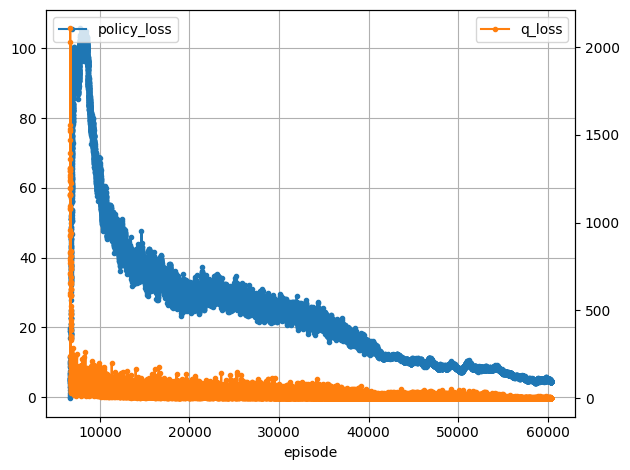

In [683]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('episode')
ax1.grid()
ax1.plot(history_metrics_y, [m[0] for m in history_metrics], color="C0", marker='.', label="policy_loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history_metrics_y, [m[1] for m in history_metrics], color="C1", marker='.', label="q_loss")
ax2.legend(loc='upper right')

fig.tight_layout()  # レイアウトの設定
#plt.savefig('cartp
# ole2.png') # 画像の保存
plt.show()
